## Multi-dimensional 0-1 knapsack problem
The solution is encoded as array of length NUM_ITEMS, where each cell is an item and the value inside represents the specific knapsack it's been assigned (from 0 to NUM_KNAPSACK-1) to or -1 if unassigned.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
from icecream import ic
import matplotlib.pyplot as plt
import math

In [2]:
NUM_KNAPSACKS = 2
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [3]:
MAX_STEPS = 10000

In [4]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [5]:
""" Check if a solution satisfies all constraints """
def valid_solution(solution):
    for kp in range(NUM_KNAPSACKS):
        if np.any(WEIGHTS[solution == kp].sum(axis = 0) > CONSTRAINTS[kp]):
            return False
    return True

In [6]:
""" Fitness function: sum of values of items in knapsacks if valid """
def fitness(solution):
    return np.sum(VALUES[solution >= 0])

In [7]:
""" Tweak function: move one item to a different knapsack or unassign it"""
def tweak(solution):
    new_solution = solution.copy()
    # Choose a random item
    i = np.random.randint(0, NUM_ITEMS)
    solution_representations = np.arange(-1, NUM_KNAPSACKS)
    # Choose a new knapsack for the item OR unassign it
    new_value = np.random.choice(solution_representations)
    while new_value == solution[i]:
        new_value = np.random.choice(solution_representations)
    new_solution[i] = new_value
    # If we unassigned an item, assign the backpack to a random unassigned item (if any)
    if new_value == -1:
        old_value = solution[i]
        unassigned_items = np.arange(NUM_ITEMS)[solution == -1]
        if len(unassigned_items) >= 1:
            j = np.random.choice(unassigned_items)
            new_solution[j] = old_value
    return new_solution

In [8]:
""" Class to store experiment results and plot fitness over time """
class ExperimentResult:
    def __init__(self, name):
        self.name = name
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -1
        self.restarts = []
    
    def add_fitness(self, fitness, solution):
        self.fitness_history.append(fitness)
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = solution.copy()
    
    def plot_fitness(self):
        fig, ax = plt.subplots()
        ax.plot(self.fitness_history)
        if len(self.restarts) > 0:
            for r in self.restarts:
                ax.axvline(r, color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Fitness")
        ax.set_title(self.name)
        ax.set_xlim(0, len(self.fitness_history))
        ax.set_ylim(0, np.sum(VALUES) * 1.1)
        ax.axhline(np.sum(VALUES), color='green', linestyle='--', alpha=0.5, label='Total maximum value')
        ax.legend(loc="lower right")
        plt.show()
        return ax
    
    def __str__(self):
        header = f"Experiment: {self.name}\n"
        best = f"Best Fitness: {self.best_fitness}\n"
        for k in range(NUM_KNAPSACKS):
            best += f" Knapsack {k}: items {np.where(self.best_solution == k)[0].tolist()}\n"
        best += f" Unassigned items: {np.where(self.best_solution == -1)[0].tolist()}\n"
        return header + best

In [9]:
""" Simulated Annealing algorithm """
def simulatedAnnealing():
    # start from a valid solution where no items are assigned
    current_solution = np.full(NUM_ITEMS, -1)
    current_obj = fitness(current_solution)
    best_solution = current_solution 
    best_obj = current_obj 
    results = ExperimentResult("Simulated Annealing")
    results.add_fitness(current_obj, current_solution)
    temp = 100
    for step in tqdm(range(MAX_STEPS)):
        new_solution = tweak(current_solution)
        new_obj = fitness(new_solution)
        if valid_solution(new_solution):
            if new_obj >= current_obj:
                current_solution = new_solution
                current_obj = new_obj            
                if new_obj > best_obj:
                    best_solution = new_solution
                    best_obj = new_obj
                
            else:
                diff = new_obj - current_obj
                p = math.exp(diff / temp)

                if np.random.rand() < p:
                    current_solution = new_solution
                    current_obj = new_obj
        temp *= 0.99
        results.add_fitness(current_obj, current_solution)
    return results

In [10]:
""" Steepest Ascent Hill Climbing algorithm """
def steepestAscentHillClimbing(num_neighbors=5):
    current_solution = np.full(NUM_ITEMS, -1)
    current_obj = fitness(current_solution)
    best_solution = current_solution 
    best_obj = current_obj 
    results = ExperimentResult("Steepest Ascent Hill Climbing")
    results.add_fitness(current_obj, current_solution)
    for step in tqdm(range(MAX_STEPS)):
        neighbors = []
        neighbor_objs = []
        for _ in range(num_neighbors):
            new_solution = tweak(current_solution)
            if valid_solution(new_solution):
                neighbors.append(new_solution)
                neighbor_objs.append(fitness(new_solution))
        if len(neighbors) == 0:
            results.add_fitness(current_obj, current_solution)
            continue
        max_index = np.argmax(neighbor_objs)
        max_obj = neighbor_objs[max_index]
        if max_obj > current_obj:
            current_solution = neighbors[max_index]
            current_obj = max_obj
            if current_obj > best_obj:
                best_solution = current_solution
                best_obj = current_obj
        results.add_fitness(current_obj, current_solution)
    return results

## TEST PROBLEMS

In [11]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

  0%|          | 0/10000 [00:00<?, ?it/s]

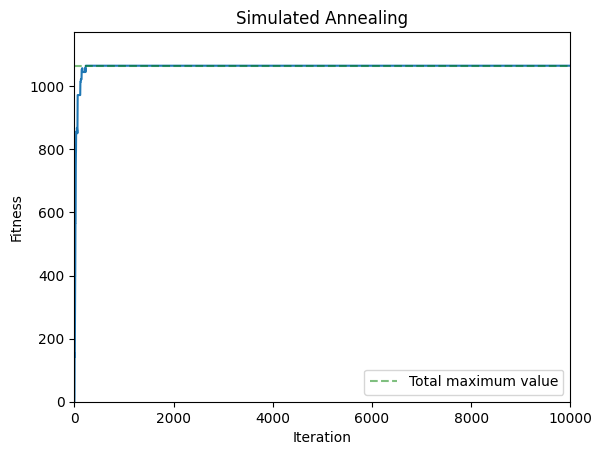

Experiment: Simulated Annealing
Best Fitness: 1065
 Knapsack 0: items [4, 5, 6, 7, 8, 11, 13, 16, 17, 19]
 Knapsack 1: items [0, 1, 2, 3, 9, 10]
 Knapsack 2: items [12, 14, 15, 18]
 Unassigned items: []



In [12]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)

  0%|          | 0/10000 [00:00<?, ?it/s]

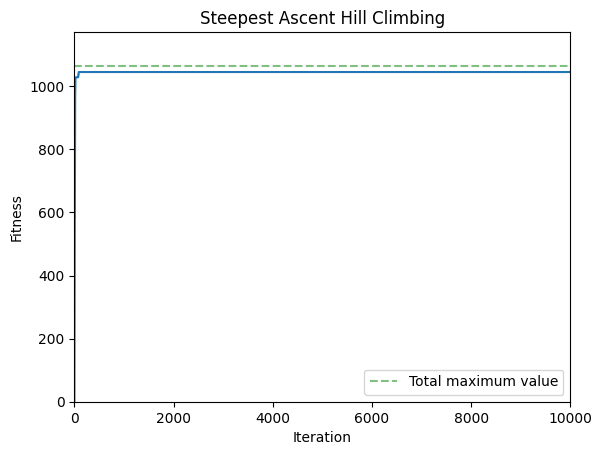

Experiment: Steepest Ascent Hill Climbing
Best Fitness: 1045
 Knapsack 0: items [0, 1, 2, 4, 5, 10, 13, 15, 16, 17]
 Knapsack 1: items [3, 6, 7, 9, 12, 18]
 Knapsack 2: items [11, 14, 19]
 Unassigned items: [8]



In [13]:
results = steepestAscentHillClimbing()
results.plot_fitness()
print(results)

In [14]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS,size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

  0%|          | 0/10000 [00:00<?, ?it/s]

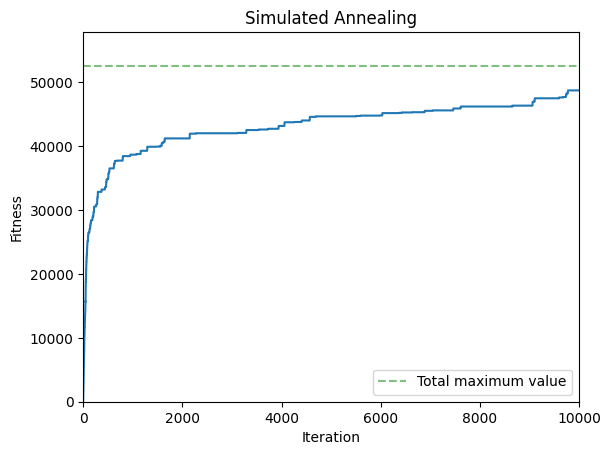

Experiment: Simulated Annealing
Best Fitness: 48756
 Knapsack 0: items [12, 28, 46, 61, 64, 66, 98]
 Knapsack 1: items [23, 26, 27, 36, 45, 47, 60, 70]
 Knapsack 2: items [7, 15, 25, 38, 44, 48, 80]
 Knapsack 3: items [14, 20, 24, 41, 52, 62, 69, 74, 91, 92, 97]
 Knapsack 4: items [3, 34, 49, 58, 63, 79, 81, 84, 88, 93]
 Knapsack 5: items [5, 29, 53, 56, 68, 83, 85, 87, 99]
 Knapsack 6: items [1, 11, 33, 39, 43, 54, 78, 94]
 Knapsack 7: items [6, 31, 37, 59, 75, 82]
 Knapsack 8: items [4, 13, 30, 35, 50, 76, 86]
 Knapsack 9: items [2, 8, 17, 18, 21, 42, 65, 72, 77, 89, 95]
 Unassigned items: [0, 9, 10, 16, 19, 22, 32, 40, 51, 55, 57, 67, 71, 73, 90, 96]



In [15]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)

  0%|          | 0/10000 [00:00<?, ?it/s]

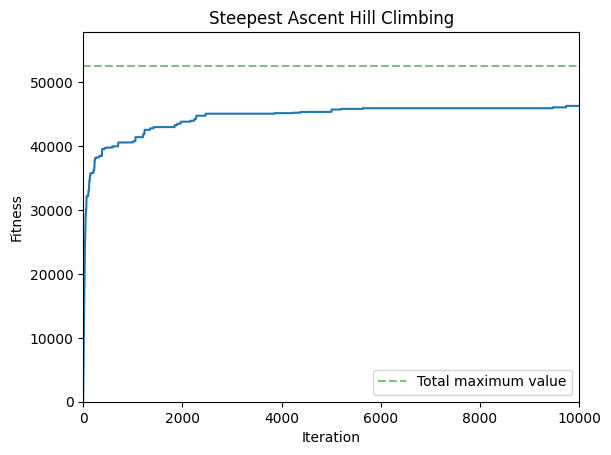

Experiment: Steepest Ascent Hill Climbing
Best Fitness: 46327
 Knapsack 0: items [30, 37, 45, 48, 92, 94]
 Knapsack 1: items [5, 31, 43, 49, 50, 81, 89, 90]
 Knapsack 2: items [27, 36, 69, 98]
 Knapsack 3: items [9, 14, 15, 20, 44, 61, 66, 84, 97, 99]
 Knapsack 4: items [7, 12, 19, 42, 46, 58, 59, 63, 74, 78, 95]
 Knapsack 5: items [18, 28, 29, 33, 39, 41, 85, 91]
 Knapsack 6: items [1, 11, 23, 47, 60]
 Knapsack 7: items [26, 34, 79, 83]
 Knapsack 8: items [4, 8, 24, 68, 72, 80, 87, 88]
 Knapsack 9: items [2, 13, 16, 25, 52, 53, 56, 65, 70, 93]
 Unassigned items: [0, 3, 6, 10, 17, 21, 22, 32, 35, 38, 40, 51, 54, 55, 57, 62, 64, 67, 71, 73, 75, 76, 77, 82, 86, 96]



In [16]:
results = steepestAscentHillClimbing()
results.plot_fitness()
print(results)

In [17]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [18]:
MAX_STEPS = 20000

  0%|          | 0/20000 [00:00<?, ?it/s]

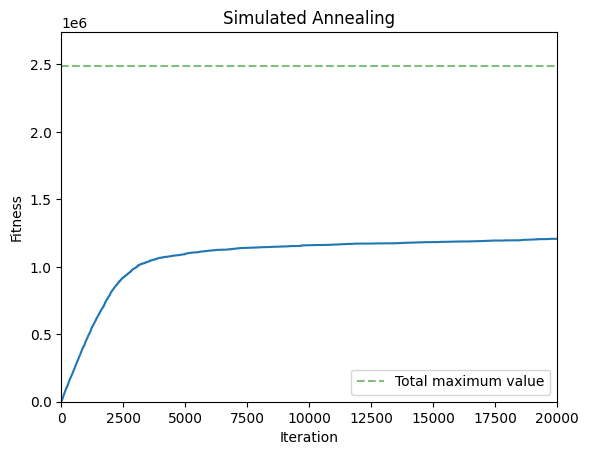

Experiment: Simulated Annealing
Best Fitness: 1207644
 Knapsack 0: items [333, 777, 788, 1022, 1153, 1186, 1300, 1331, 1579, 1743, 1807, 1810, 1982, 2057, 2443, 2455, 2870, 2876, 2908, 3055, 3522, 3893, 4242, 4897]
 Knapsack 1: items [43, 352, 752, 951, 1007, 1135, 1477, 2303, 2347, 2357, 2410, 2502, 2520, 2710, 2804, 3069, 3088, 3341, 3768, 3904, 3967, 4377, 4500, 4589, 4740, 4854, 4873]
 Knapsack 2: items [573, 988, 1112, 1144, 1268, 1330, 1506, 1661, 1715, 2555, 3186, 3458, 3894, 3957, 4137, 4147, 4280, 4435, 4571, 4620, 4926]
 Knapsack 3: items [17, 321, 448, 632, 914, 943, 1292, 1529, 1746, 1750, 2117, 2159, 3239, 3263, 3706, 3795, 4071, 4077, 4151, 4262, 4307, 4327, 4451, 4483, 4903, 4992]
 Knapsack 4: items [255, 634, 667, 693, 1099, 1547, 1790, 1798, 1808, 1900, 1943, 2301, 2343, 2353, 2563, 3261, 3288, 3449, 3730, 3902, 3999, 4070, 4285, 4297, 4530, 4708, 4875]
 Knapsack 5: items [224, 608, 891, 994, 1221, 1234, 1513, 1665, 1685, 1830, 2021, 2426, 2431, 2921, 3537, 3610, 3735,

In [19]:
results = simulatedAnnealing()
results.plot_fitness()
print(results)

  0%|          | 0/20000 [00:00<?, ?it/s]

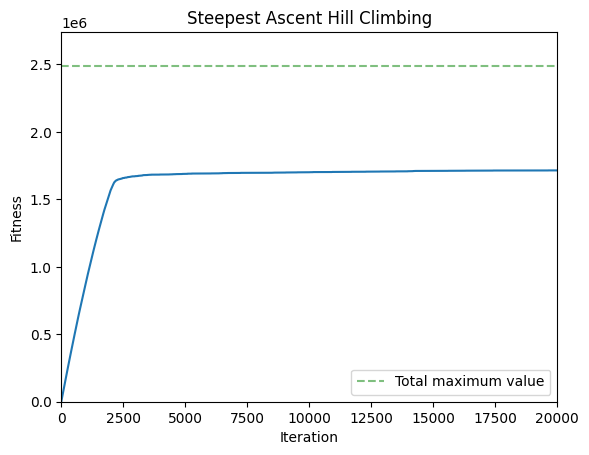

Experiment: Steepest Ascent Hill Climbing
Best Fitness: 1714701
 Knapsack 0: items [14, 125, 403, 557, 576, 756, 860, 942, 981, 1055, 1080, 1135, 1309, 1584, 1688, 1883, 2623, 2639, 2667, 2836, 2841, 3554, 3644, 3663, 4141, 4651, 4972]
 Knapsack 1: items [118, 469, 548, 550, 661, 1087, 1092, 1633, 1673, 2244, 2346, 2964, 3219, 3220, 3380, 3444, 3687, 3727, 3913, 4339, 4421, 4912, 4918]
 Knapsack 2: items [233, 325, 679, 917, 1031, 1324, 1456, 1949, 2056, 2350, 2654, 2721, 2754, 3054, 3210, 3625, 3872, 3975, 4278, 4310, 4373, 4700]
 Knapsack 3: items [47, 602, 962, 1041, 1470, 1522, 1594, 1751, 1860, 1986, 1996, 2140, 2141, 2493, 2940, 2984, 3392, 3428, 3570, 3620, 4744]
 Knapsack 4: items [178, 263, 374, 429, 722, 1210, 1303, 1405, 1600, 1613, 1695, 1920, 2072, 2154, 2283, 2402, 2515, 2777, 2944, 3411, 3721, 4146, 4222, 4319, 4362, 4668, 4759]
 Knapsack 5: items [815, 968, 1140, 1489, 1563, 1658, 2024, 2041, 2053, 2354, 2389, 2689, 2712, 2821, 2837, 3096, 3117, 3299, 3473, 3777, 4036, 

In [20]:
results = steepestAscentHillClimbing(num_neighbors=25)
results.plot_fitness()
print(results)